In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import sqlite3
from functools import wraps
import json
import os

In [2]:
plt.rcParams['figure.dpi'] = 120

# Chapter 6
##### 简化版

In [3]:
class Person:
    alpha = 0.8    # 轻信度
    def __init__(self, id):
        self.id = id
        self.init = np.random.uniform(0, 1)   # 信息偏好初始值（随机）
        self.temp = self.init                 # 之后会动态更新信息偏好
    
    def __repr__(self):
        return 'Person(%r)' % self.id
    
    def __str__(self):
        return str(self.id)
    
    def step(self, neighbors):
        """ 与所有邻居信息交互，最终结合初始值更新temp """
        s = self.temp
        for neighbor in neighbors:
            s += neighbor.temp
        s /= (len(neighbors) + 1)
        self.temp = (1 - self.alpha) * self.init + self.alpha * s    
    
    def interact(self, other):
        """ 
        与某一个人而不是全部邻居交换信息
        影响值s取算术平均
        返回权重值（之后建立带权重连接：两个人意见越相似，权重越大）
        """
        s = (self.temp + other.temp) / 2
        self.temp = (1 - self.alpha) * self.init + self.alpha * s
        return 1 - np.abs(self.temp - other.temp)

    
def initialize_graph(n, density):
    """
    初始化含n个节点的随机网络
    节点间以density的概率建立连接 """
    g = nx.Graph()
    for i in range(n):
        g.add_node(Person(i))
    nodes = g.nodes()

    for x, y in combinations(nodes, 2):
        if np.random.uniform(0, 1) <= density: 
            g.add_edge(x, y)
    return g


def once_update(g, method):
    """
    对图进行一次更新
    method=1：对应节点的step方法，与所有邻居信息交互，更新节点信息值
    method=2：对应节点的interact方法，与某个节点交互，并依据节点信息值相似性建立带权边
    
    """
    if method == 1:
        for node in g.nodes():
            neighbors = g[node].keys()
            node.step(neighbors)
    if method == 2:    # 随机挑选一个除自己外的其他节点交换信息
        for node in g.nodes():
            others = set(g.nodes()) - set([node])    
            partner = np.random.choice(list(others))
            weight = node.interact(partner)
            g.add_edge(node, partner, weight=weight)  # 依据节点相似性建立带权边


def update_and_draw(g, method, times):
    """
    对图更新times次，每次对节点-信息值画折线图
    最后一次用红色粗线标记
    """
    for i in range(times):
        once_update(g, method)
        if i < times - 1:
            plt.plot([n.temp for n in g.nodes()])
        else:
            plt.plot([n.temp for n in g.nodes()], color='red', linewidth=2)
            plt.xlabel('Person')
            plt.ylabel('Information')

            
def draw_graph(g, method):
    """ 
    画整个网络图 
    method=1: 节点颜色表示信息偏好值(越浅数值越大)；节点标签设为信息偏好值
    method=2: 节点颜色表示信息偏好值,不显示节点标签，边的粗细表示边的权重
    """
    pos = nx.spring_layout(g)
    node_color = [n.temp for n in g.nodes()]
    if method == 1:
        labels = {n: '{:.2f}'.format(n.temp) for n in g.nodes()}
        nx.draw(g, pos, node_color=node_color, labels=labels)
    if method == 2:  
        edge_color = [edata.get('weight', 0) for from_, to, edata in g.edges(data=True)]
        nx.draw(g, pos, node_color=node_color, edge_color=edge_color)

* <font color=purple>大众：按照 $method=1$ 更新（改变的只有信息值，网络结构不变）
    * 轻信度 $alpha=0.8$

D:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


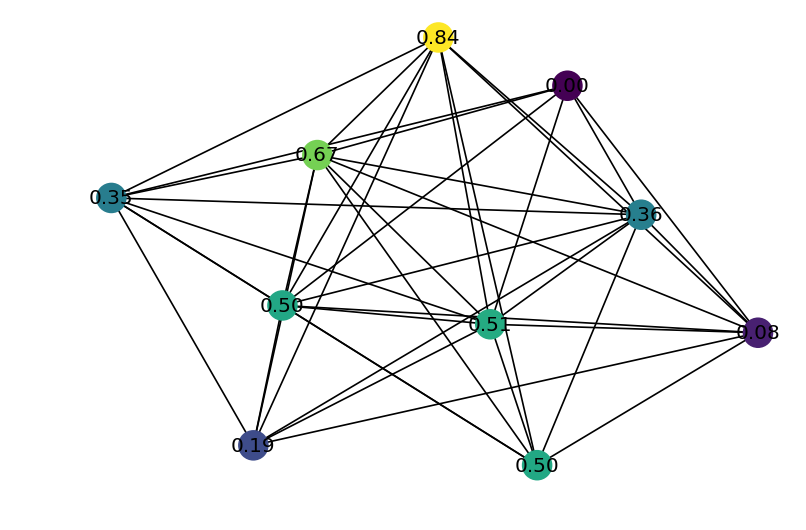

In [4]:
# 初始化网络
g = initialize_graph(10, 0.9)
draw_graph(g, method=1)

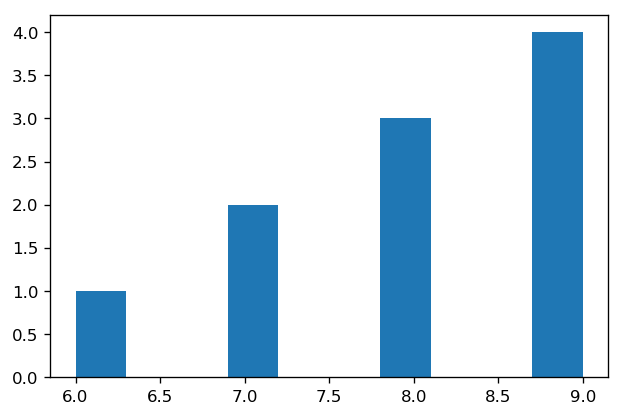

In [5]:
# 初始网络的度数直方图
plt.hist(dict(nx.degree(g)).values());

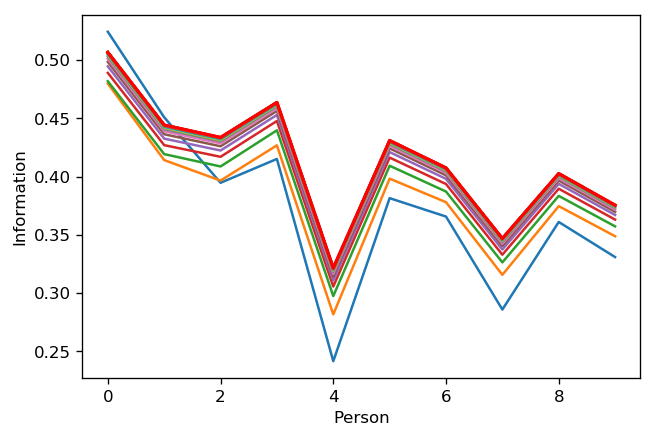

In [6]:
# 更新网络30次
update_and_draw(g, method=1, times=30)

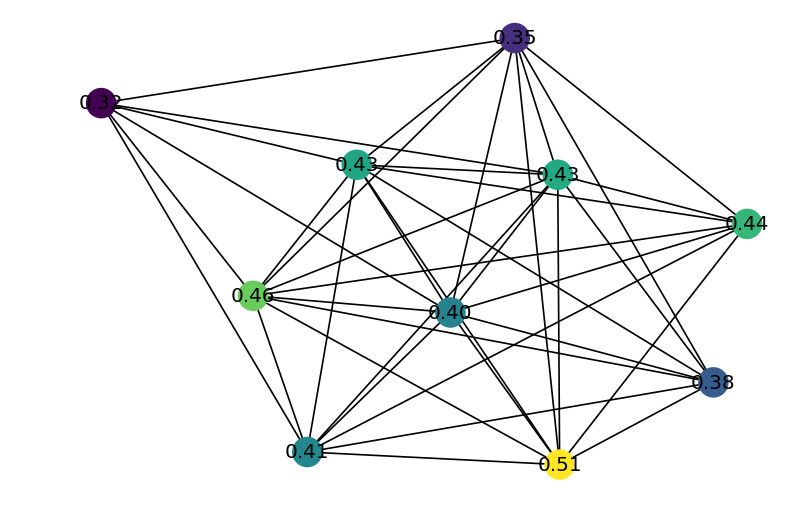

In [7]:
# 更新完成后的图
draw_graph(g, method=1)

* <font color=purple>大众：按照 $method=1$ 更新（改变的只有信息值，网络结构不变）
    * 轻信度 $alpha=1$ (人们非常轻信)

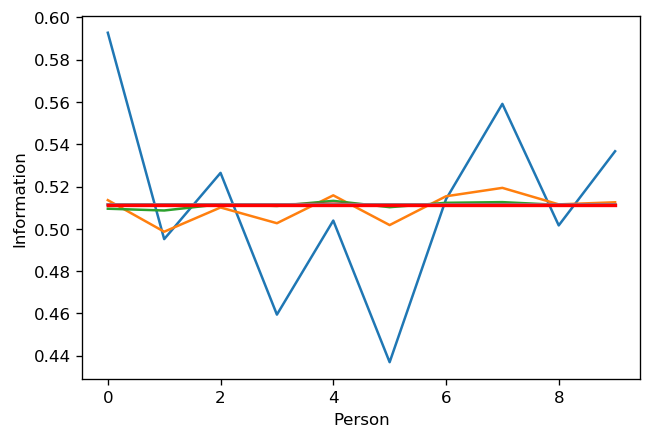

In [8]:
Person.alpha = 1   # 人们非常轻信
g = initialize_graph(10, 0.9)    # 随机初始化网络
update_and_draw(g, method=1, times=30)   # 观察图形，很快达成共识（水平线）

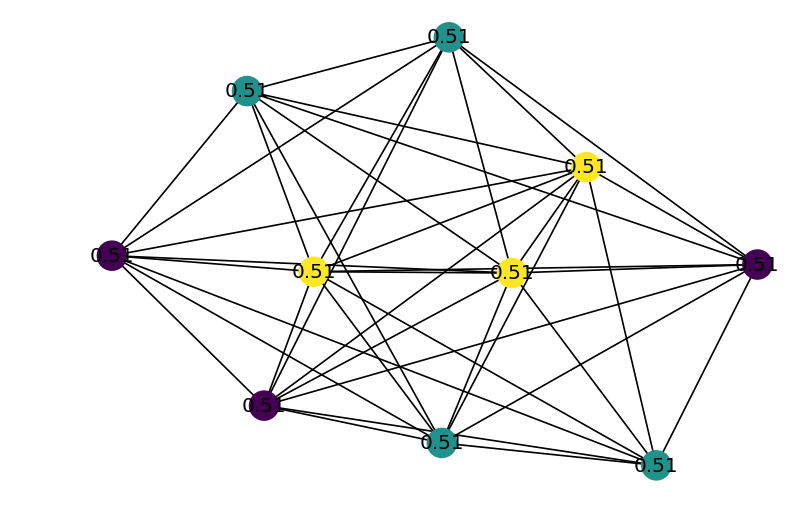

In [9]:
# 更新完成后的图
draw_graph(g, method=1)

* <font color=purple>大众 + 影响者：按照 $method=1$ 更新（改变的只有信息值，网络结构不变）
    * 轻信度 $alpha=0.8$

In [10]:
class Influencer(Person):
    """ 宣传主体，如传教士等，对信息始终认为是1"""
    def __init__(self, id):
        self.id = id
        self.temp = 1
    
    def __repr__(self):
        return 'Influencer(%r)' % self.id
    
    def step(self, neighbors):
        pass  # 意见不可动摇

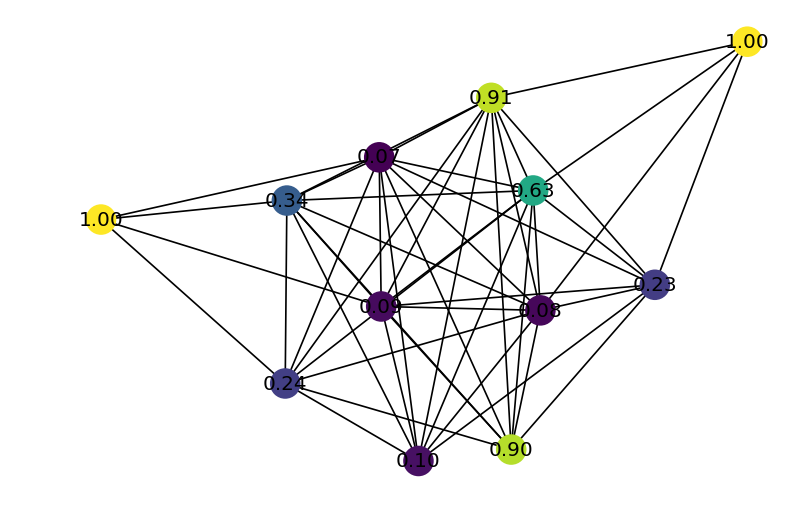

In [11]:
n_influencers = 2   # 加入影响者人数
n_connections = 4   # 每个影响者与大众建立的连接数
Person.alpha = 0.8  # 恢复轻信度默认值0.8

g = initialize_graph(10, 0.9)  # "普通人"建立网络
persons = list(g.nodes())      # "普通人"
for i in range(n_influencers):
    inf = Influencer("Inf" + str(i))
    for person in np.random.choice(persons, n_connections, replace=False):
        g.add_edge(person, inf)

draw_graph(g, method=1)     # 含影响者的初始网络可视化

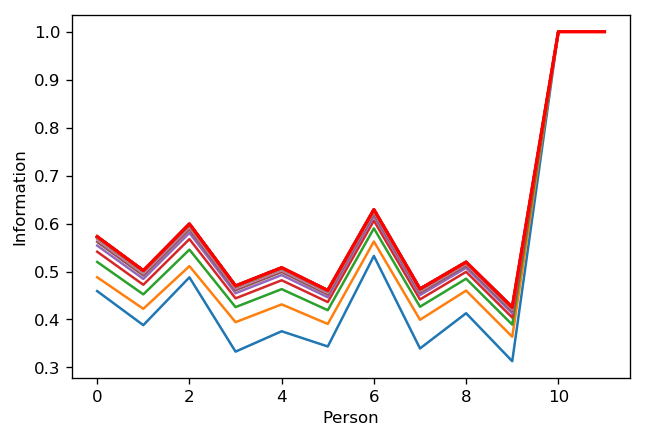

In [12]:
# 更新含影响者的网络30次
update_and_draw(g, method=1, times=30)

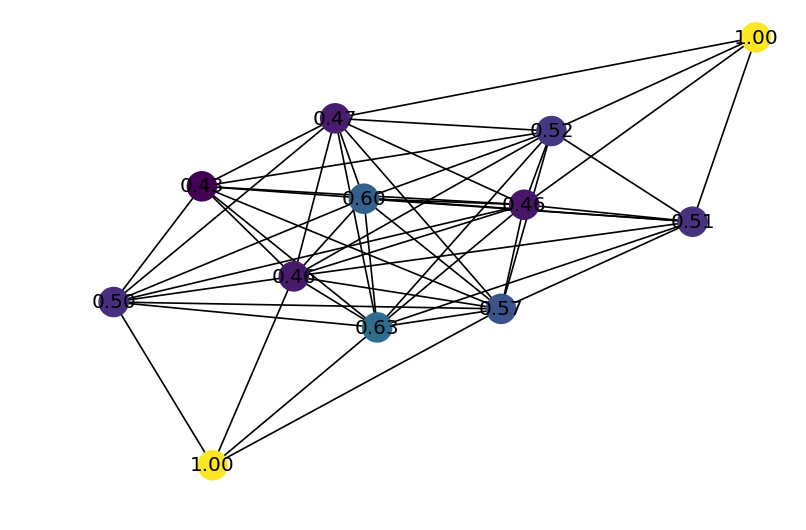

In [13]:
# 更新完成后的图
draw_graph(g, method=1)

* <font color=purple>大众：按照 $method=2$ 更新（信息值和网络结构同时演化）；轻信度默认 $alpha=0.8$

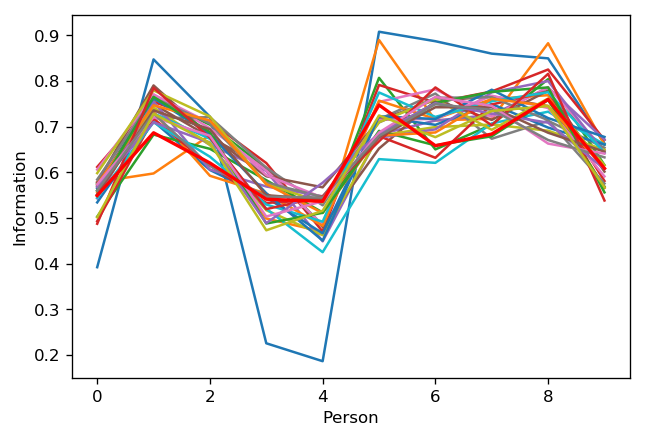

In [14]:
g = initialize_graph(10, 0.9)
update_and_draw(g, method=2, times=30)

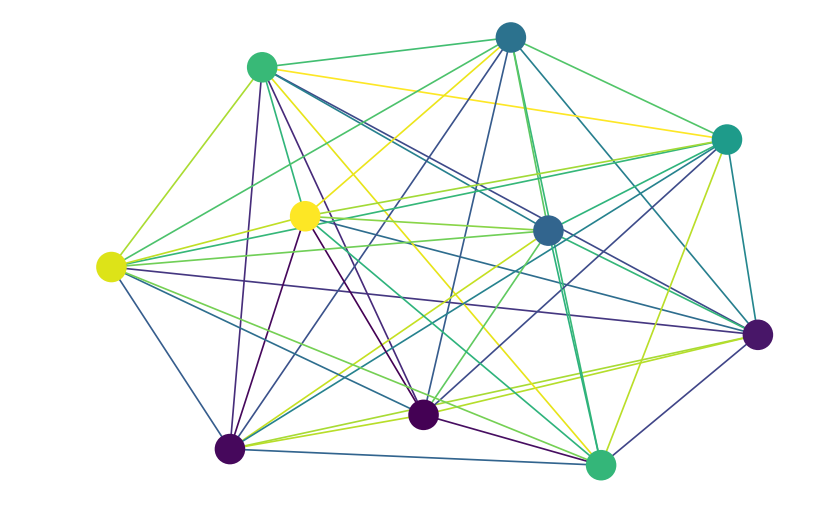

In [15]:
# 更新完成后的图
draw_graph(g, method=2)

##### 终极版
1.基于规则选择交互对象（见代码）

2.信息更新后，根据信息值的相似度与交互对象建立带权边：越相似则权重越大

3.每次更新后，各边权重以 $1-decay\_rate$ 的比率衰减，低于 $threshold$ 的边被丢弃

In [16]:
# 参数设置（参照GitHub）
alpha = 0.9          # 轻信度
decay_rate = 0.01    # 边权重衰减速度
threshold = 0.1      # 每次更新后丢弃权重小于阈值的边
density = 0.05        # 初始化网络时随机建立边的概率
n = 100              # 初始化网络节点个数
times = 200          # 更新200轮

In [17]:
class Person:
    alpha = alpha
    
    def __init__(self, id):
        self.id = id
        self.init = np.random.uniform(0, 1)
        self.temp = self.init
    
    def __repr__(self):
        return 'Person(%r)' % self.id
    
    def __str__(self):
        return str(self.id)
    
    def _roulette_choice(self, neighbors_info, others):
        """
        选择交互对象
        """
        neighbors = list(neighbors_info.keys())
        weights = np.array([edata['weight'] for edata in neighbors_info.values()])

        # 假设一个节点以0.6的概率喜欢与相似对象交互，以0.3的概率喜欢与有差异对象交互，0.1的概率随机交互；roll点确定偏好类型
        # 选择交互对象时的相似性指边权重
        roll = np.random.uniform(0, 1)   
        if roll <= 0.1 or len(neighbors) == 0:       # 没有邻居或者随机交互偏好
            partner = np.random.choice(list(others))  # 从其他节点随机选择
        else:
            if roll <= 0.4:     # 以0.3的概率喜欢与有差异对象交互
                weights = 1 - weights      # 权重反转
            p = weights / np.sum(weights)  # 归一化概率
            partner =  np.random.choice(neighbors, p=p)
        return partner
        
    def interact(self, other):
        """ 信息交互 """
        s = (self.temp + other.temp) / 2
        self.temp = (1 - self.alpha) * self.init + self.alpha * s
        return 1 - np.abs(self.temp - other.temp)   # 返回信息值相似度（0-1）


def initialize_graph(n, density):
    """
    初始化一个n节点的随机图
    节点间以density的概率建立连接,边权重服从Uniform[0,1]
    """
    g = nx.Graph()
    for i in range(n):
        g.add_node(Person(i))
    
    nodes = g.nodes()
    for x, y in combinations(nodes, 2):
        if np.random.uniform(0, 1) <= density: 
            g.add_edge(x, y, weight=np.random.uniform(0, 1))
    return g


def describe_info(g):
    """ 对整个图当前信息值的描述性统计"""
    info = np.array([n.temp for n in g.nodes()])
    return np.min(info), np.max(info), np.mean(info)


def draw_graph(g):
    """ 
    画整个网络图 
    """
    pos = nx.spring_layout(g)
    node_color = [n.temp for n in g.nodes()]
    edge_color = [edata.get('weight', 0) for from_, to, edata in g.edges(data=True)]
    nx.draw(g, pos, node_color=node_color, edge_color=edge_color, node_size=50)

    
def once_update(g):
    """
    对图进行一次更新

    """
    nodes = list(g.nodes())
    for node in nodes:
        neighbors_info = g[node]
        others = set(nodes) - set([node])
        partner = node._roulette_choice(neighbors_info, others)
        similarity = node.interact(partner)
        g.add_edge(node, partner, weight=similarity)
        
        
def update_and_draw(g, times, decay_rate, threshold):
    """
    对图更新times次，每次对节点-信息值画折线图
    每次边权重以 1-decay_rate 的比率衰减，权重低于threshold的边被丢弃
    最后一次用红色粗线标记
    """
    statistic = []    # 每次更新收集统计信息
    for i in range(times):
        once_update(g)
        
        drop_edges = []
        for from_, to, edata in g.edges(data=True):
            edata['weight'] = edata['weight'] * (1 - decay_rate)   # 权重衰减
            if edata['weight'] < threshold:        # 丢弃边
                drop_edges.append((from_, to)) 
        g.remove_edges_from(drop_edges)
        
        statistic.append(describe_info(g))
        
        if i < times - 1:
            plt.plot([n.temp for n in g.nodes()])
        else:
            plt.plot([n.temp for n in g.nodes()], color='red', linewidth=2)
            plt.xlabel('Person')
            plt.ylabel('Information')
    return statistic

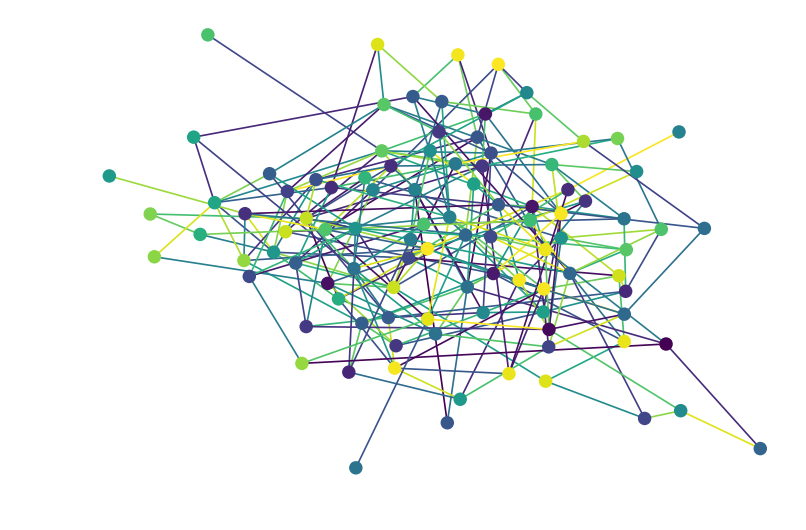

In [18]:
# 初始图
g = initialize_graph(n, density)
draw_graph(g)

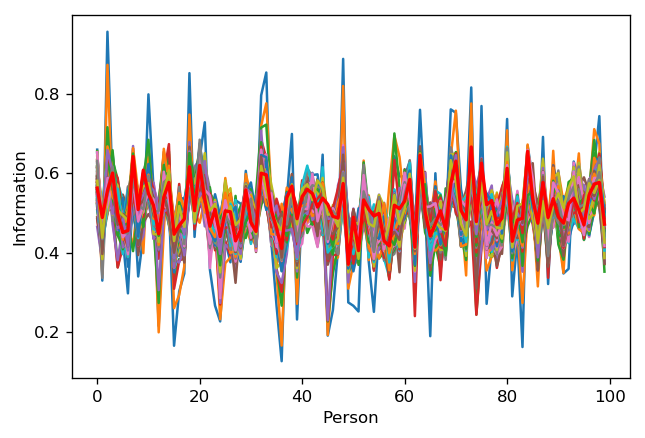

In [19]:
# 更新过程各节点信息值的折线图
statistic = update_and_draw(g, times, decay_rate, threshold)

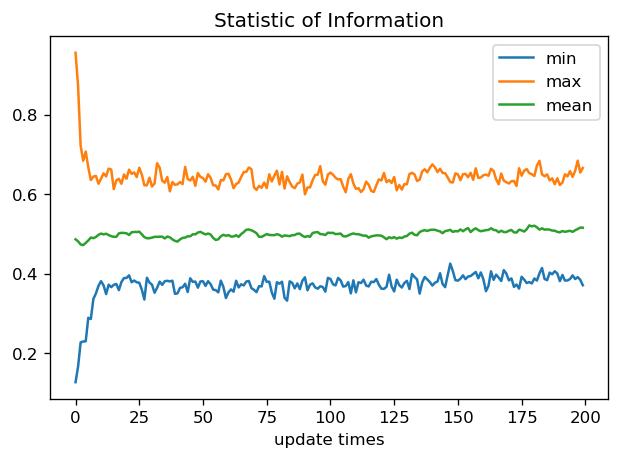

In [20]:
# 更新过程信息值的最小、最大、平均值
plt.plot(statistic);
plt.legend(['min', 'max', 'mean']);
plt.title("Statistic of Information");
plt.xlabel("update times");

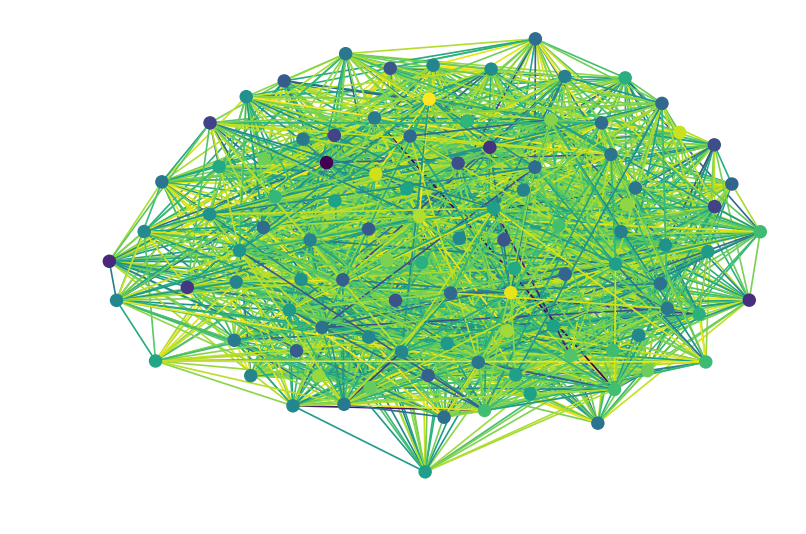

In [21]:
# 更新完成后的图
draw_graph(g)

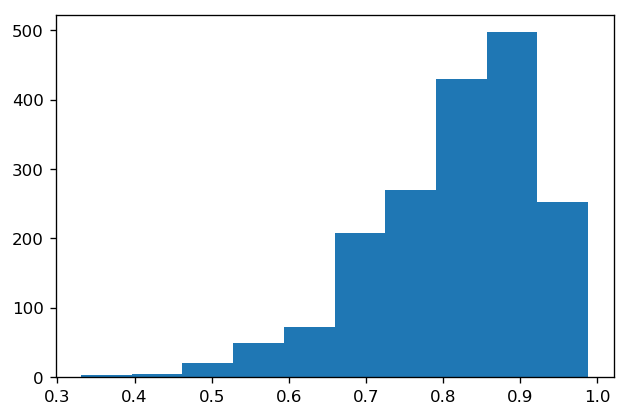

In [22]:
# 更新完成后边权重的直方图
plt.hist([edata['weight'] for from_, to, edata in g.edges(data=True)]);

# Chapter 7

In [23]:
# 待装饰的函数是SqlGraph类方法，第一个参数是实例对象
def cursored(func):
    @wraps(func)
    def wrapper(sqlgraph, *args, **kwargs):
        sqlgraph.cur = sqlgraph.con.cursor()
        result = func(sqlgraph, *args, **kwargs)
        sqlgraph.con.commit()
        sqlgraph.cur.close()
        return result
    return wrapper

In [24]:
class SqlGraph:
    """ 图与数据库交互
        注意这里图节点只能是序列化对象（数值、字符串等）！！！"""
    
    def __init__(self, db_path):
        """ db_path: /xxx/xxx/yyy.db, yyy最好是图片名称
            连接到数据库，如果没有则创建
        """
        # 获取图名称
        _, filename = os.path.split(db_path)
        g_name ,_ = os.path.splitext(filename)
        
        self.g_name = g_name
        self.con = sqlite3.connect(db_path)
        
        # 没有则创建两张表分别保存节点和边
        # "点表" 字段：node， attributes
        # "边表"字段： efrom , eto, attributes
        cur = self.con.cursor()
        cur.execute("""CREATE TABLE IF NOT EXISTS {}_nodes (node, attributes)""".format(g_name))
        cur.execute("""CREATE TABLE IF NOT EXISTS {}_edges (efrom, eto, attributes)""".format(g_name))
        cur.close()
    
    @cursored
    def add_node(self, node, attr_dict=None):
        attributes = json.dumps(attr_dict)
        self.cur.execute("""INSERT OR REPLACE INTO {}_nodes (node, attributes) VALUES(?,?)""".format(self.g_name), (node, attributes))
    
    @cursored
    def remove_node(self, node):
        self.cur.execute("""DELETE FROM {}_nodes WHERE node=?""".format(self.g_name), (node,))
    
    @cursored
    def add_edge(self, efrom, eto, attr_dict=None):
        attributes = json.dumps(attr_dict)
        self.cur.execute("""INSERT OR REPLACE INTO {}_edges (efrom, eto, attributes) VALUES(?,?,?)""".format(self.g_name), (efrom, eto, attributes))
    
    @cursored
    def remove_edge(self, efrom, eto):
        self.cur.execute("""DELETE FROM {}_edges WHERE efrom=? AND eto=?""".format(self.g_name), (efrom, eto))
    
    @cursored
    def write_sqlite(self, g):
        self.cur.execute("""DELETE FROM {}_nodes""".format(self.g_name))
        self.cur.execute("""DELETE FROM {}_edges""".format(self.g_name))
        
        for node, attr_dict in g.node.items():
            self.add_node(node, attr_dict)
        for efrom, eto, attr_dict in g.edges(data=True):
            self.add_edge(efrom, eto, attr_dict)
    
    @cursored
    def read_sqlite(self):
        g = nx.Graph()
        for row in self.cur.execute("""SELECT * FROM {}_nodes""".format(self.g_name)):
            g.add_node(row[0], **json.loads(row[1]))
        for row in self.cur.execute("""SELECT * FROM {}_edges""".format(self.g_name)):
            g.add_edge(row[0], row[1], **json.loads(row[2]))
        return g
    
    @cursored
    def get_node_data(self, node):
        result = self.cur.execute("""SELECT * FROM {}_nodes WHERE node=?""".format(self.g_name), (node,))
        for row in result:
            return json.loads(row[1])
        else:
            raise Exception("Node {} is not in graph.".format(node))
    
    @cursored
    def get_edge_data(self, efrom, eto):
        result = self.cur.execute("""SELECT * FROM {}_edges WHERE efrom=? AND eto=?""".format(self.g_name), (efrom, eto))
        for row in result:
            return json.loads(row[2])
        else:
            raise Exception("Edge {}-{} is not in graph.".format(efrom, eto))

###### 测试

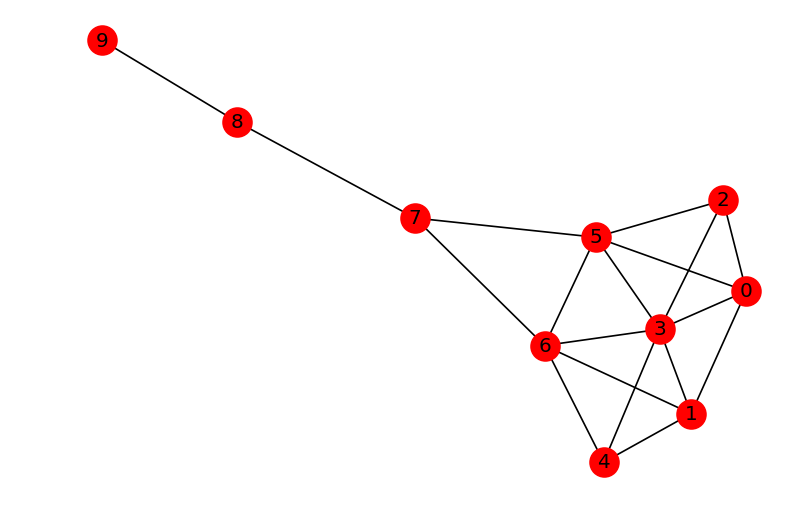

In [25]:
sg = SqlGraph(r"kite.db")
g = nx.krackhardt_kite_graph()
nx.draw(g, with_labels=True)

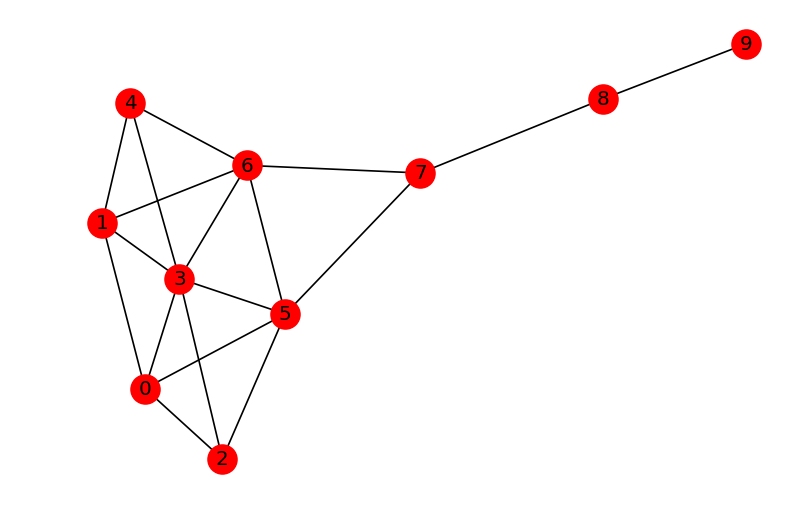

In [26]:
# 将图写入数据库，再读出
sg.write_sqlite(g)
rg = sg.read_sqlite()
nx.draw(rg, with_labels=True)

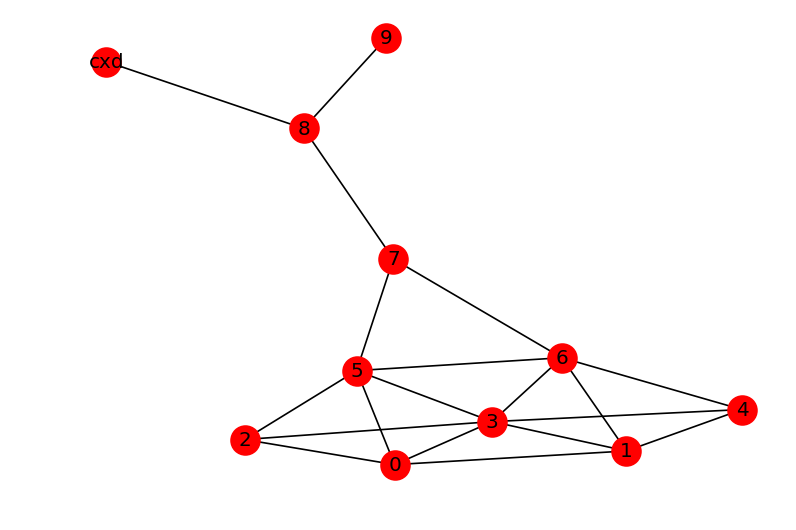

In [27]:
sg.add_node("cxd", {"age": 26})
sg.add_edge("cxd", 8, {"link": "my_link"})
nx.draw(sg.read_sqlite(), with_labels=True)

In [28]:
sg.get_node_data("cxd")

{'age': 26}

In [29]:
sg.get_edge_data("cxd", 8)

{'link': 'my_link'}

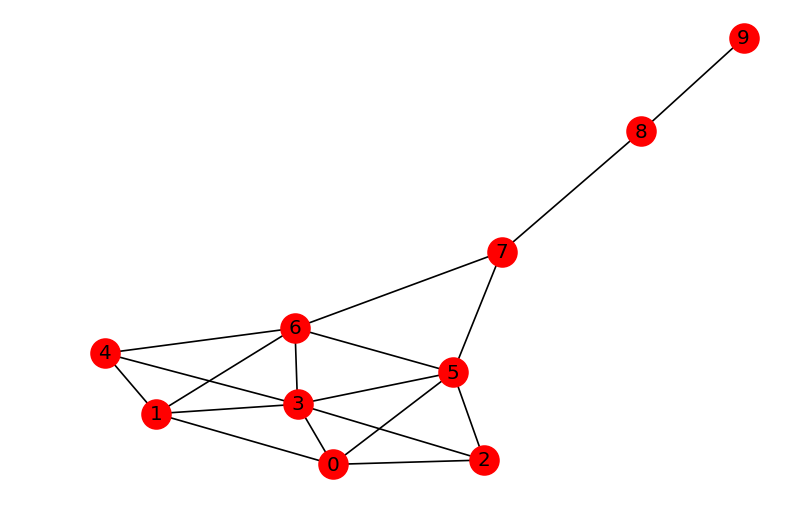

In [30]:
sg.remove_node("cxd")
sg.remove_edge("cxd", 8)
nx.draw(sg.read_sqlite(), with_labels=True)

In [31]:
sg.con.close()